# High Level Pipline for GCN and GNODE for Brain State Identification

## Pipeline Overview

### 1.1 Adjacency Matrix Generation ---> **2.1 Unsupervised GCN** ---> 3.1 Supervised MLP

### 1.1 Adjacency Matrix Generation ---> **2.2 Unsupervised GNODE** ---> 3.1 Supervised MLP

[Introduction and overview should be written here]

#### High Level Classes imported:

DataManager.py DataManagerUtil.py : [insert description here]

GCN.py GCNutil.py : [insert description here]

GDE.py GDEutil.py GDEsolvers.py : [insert description here]

MLP.py : [insert description here]

In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

#### Dataset:

[A short description here]

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------
print sample EGG signal from one node:


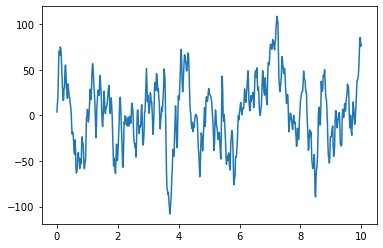

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_620.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [32]:
#OPTIONAL: Shuffle the dataset
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, print_summary = True)

KeyboardInterrupt: 

In [101]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

In [5]:
#save the shuffled indices
np.save("datasets/indices_253.npy",indices)

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 1.1 Adjacency Matrix Generation

[short description here]

##### 1.1.1 Create the datamanager object that computes the covariance matrix for you.

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
dm.apply_variance_filter(16)
print(dm)

X_train: shape of(1387, 31, 640)
X_test: shape of(1487, 31, 640)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(31, 31)
A_test: shape of(31, 31)
P_avg_train: shape of(31, 31)
P_avg_test: shape of(31, 31)
--------data successfully filtered--------
X_train: shape of(1387, 16, 640)
X_test: shape of(1487, 16, 640)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(16, 16)
A_test: shape of(16, 16)
P_avg_train: shape of(16, 16)
P_avg_test: shape of(16, 16)


##### 1.1.2 Visualize the mean covariance matrix across all training samples

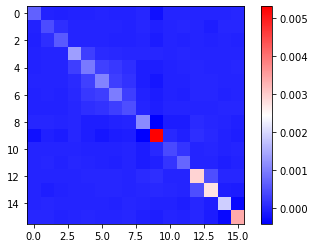

In [5]:
show_heat_map(dm.P_avg_train)

##### 1.1.3 Create DAD from dm by setting the threshold n. repeating this untill a desireble "n" value is found.

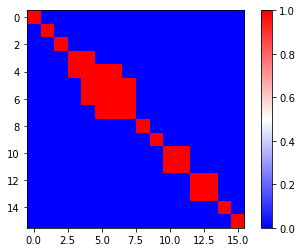

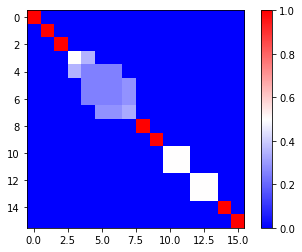

In [7]:
n = 1.5*10**-4
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Convolutional Neural Network (GCN)

[short description here]

##### 2.1.1 Declare Parameters for GCN

In [8]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(GCNparameters)
GCNcheckpoint = {'parameters': GCNparameters}

{'body': 640, 'M': 1387, 'batch_size': 128, 'n_layers': 2, 'num_epochs': 1, 'learning_rate': 0.001, 'weight_decay': 0.005}


##### 2.1.2 Train GCN

In [9]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GCNmodel, GCNcheckpoint = GCNutil.train_GCN(A, X_train, X_test, GCNcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/11 [00:00<?, ?it/s]

device set to cpu


  9%|▉         | 1/11 [00:00<00:02,  4.25it/s]

Epoch: 1   Batch: 1 of size 128   Train loss: 88.79105377197266   Valid loss: 77.2434310913086

 18%|█▊        | 2/11 [00:00<00:02,  4.48it/s]

Epoch:atch: 2 of size 128   Train loss: 77.59101867675781   Valid loss: 75.16030883789062

 27%|██▋       | 3/11 [00:00<00:01,  4.64it/s]

Epoch:atch: 3 of size 128   Train loss: 75.74354553222656   Valid loss: 78.5747299194336

 36%|███▋      | 4/11 [00:00<00:01,  4.76it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.75it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.73it/s]

Epoch: 1   Batch: 6 of size 128   Train loss: 78.36442565917969   Valid loss: 74.51997375488281

 64%|██████▎   | 7/11 [00:01<00:00,  4.73it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.64it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.57it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.53it/s]

Epoch: 1   Batch: 10 of size 128   Train loss: 74.18991088867188   Valid loss: 74.04753875732422

100%|██████████| 11/11 [00:02<00:00,  4.72it/s]

 1   Batch: 11 of size 128   Train loss: 75.2095718383789   Valid loss: 74.6499252319336


In [11]:
#optional: saving the model
GCNutil.save_ckp(GCNcheckpoint, "models/GCN253_1.pt")

model saved


##### 2.1.3 Visualize some simularity matrices generated by GCN (a visual evaluation and sanity check)

In [10]:
GCNmodel.eval()
test_pred = GCNmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


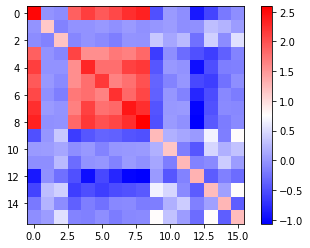

sample 1   label, 0.0


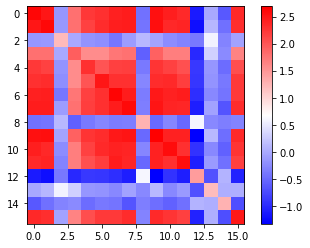

sample 2   label, 0.0


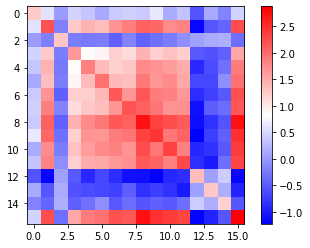

sample 3   label, 0.0


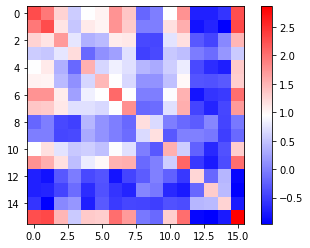

sample 4   label, 0.0


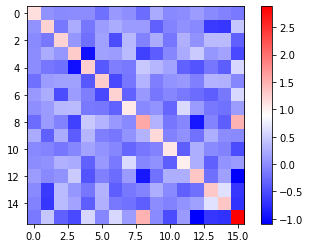

sample 5   label, 0.0


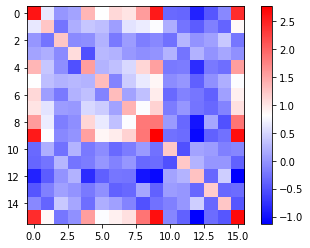

sample 6   label, 0.0


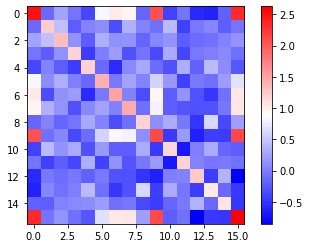

sample 7   label, 0.0


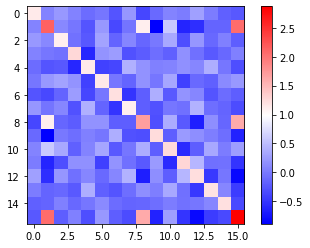

sample 8   label, 0.0


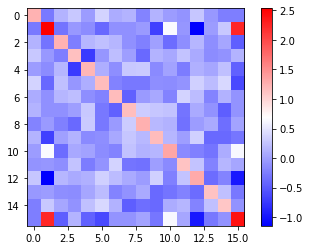

sample 9   label, 1.0


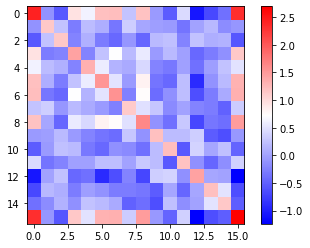

In [11]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Neural Ordinary Differential Equations (GNODE)

[short description here]

##### 2.2.1 Declare Parameters for GNODE

In [12]:
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEcheckpoint = {'parameters': GDEparameters}

##### 2.2.2 Train GNODE

In [13]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GDEmodel, GDEcheckpoint = GDEutil.train_GDE(A, X_train, X_test, GDEcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/11 [00:00<?, ?it/s]

device set to cpu


  9%|▉         | 1/11 [00:01<00:19,  1.97s/it]

 18%|█▊        | 2/11 [00:03<00:17,  1.99s/it]

 27%|██▋       | 3/11 [00:05<00:15,  1.98s/it]

 36%|███▋      | 4/11 [00:07<00:13,  1.98s/it]

 45%|████▌     | 5/11 [00:09<00:11,  1.97s/it]

 55%|█████▍    | 6/11 [00:11<00:09,  1.96s/it]

 64%|██████▎   | 7/11 [00:13<00:07,  1.97s/it]

 73%|███████▎  | 8/11 [00:15<00:05,  1.96s/it]

 82%|████████▏ | 9/11 [00:17<00:03,  1.95s/it]

 91%|█████████ | 10/11 [00:19<00:01,  1.94s/it]

100%|██████████| 11/11 [00:21<00:00,  1.93s/it]

Epoch: 1   Batch: 11 of size 128   Train loss: 71.71451568603516   Valid loss: 72.482421875


In [16]:
#optional: saving the model
GDEutil.save_ckp(GDEcheckpoint, "models/GDE253_1.pt")

model saved


##### 2.2.3 Visualize some simularity matrices generated by GNODE (a visual evaluation and sanity check)

In [14]:
GDEmodel.eval()
test_pred = GDEmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


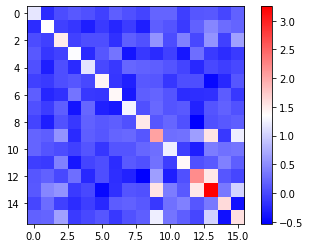

sample 1   label, 0.0


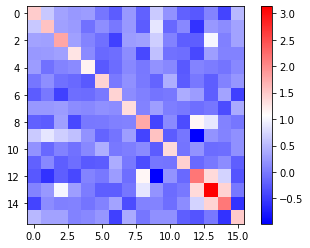

sample 2   label, 0.0


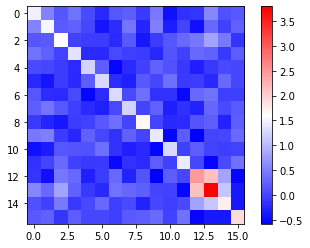

sample 3   label, 0.0


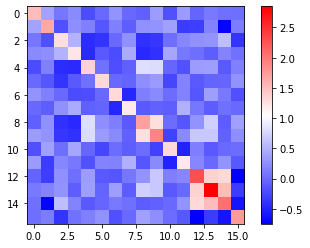

sample 4   label, 0.0


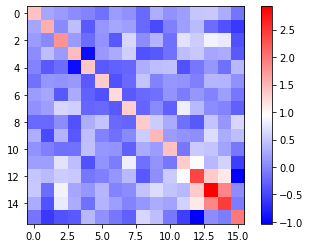

sample 5   label, 0.0


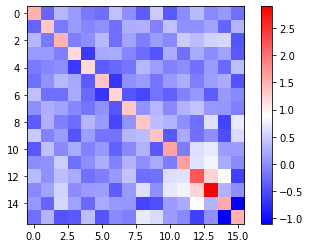

sample 6   label, 0.0


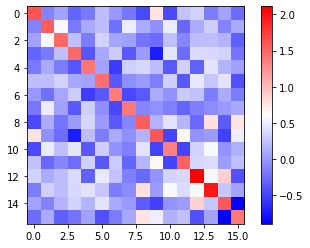

sample 7   label, 0.0


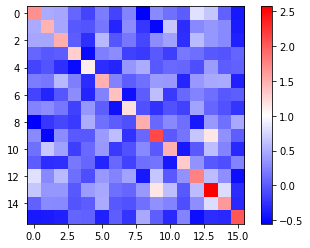

sample 8   label, 0.0


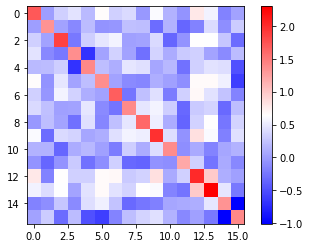

sample 9   label, 1.0


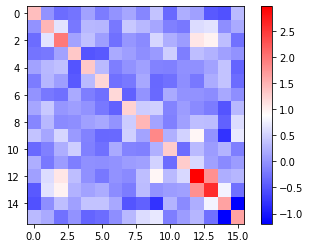

In [15]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 3.1 Supervised Multi-Layer Perceptron (MLP)

[short description here]

##### 3.1.1 Get simularity matrix from GCN and GNODE models

In [16]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'

In [17]:
#Get simularity matrix from GCN
GCNmodel.eval()
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

In [18]:
#Get simularity matrix from GNODE
GDEmodel.eval()
sim_all["GDE_train"] = GDEmodel(torch.from_numpy(X_train).float().to(device_name)).cpu().detach().numpy()
sim_all["GDE_test"] = GDEmodel(torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()

##### 3.1.2 Visualize the averaged ictal and non-ictal states for the two models

Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


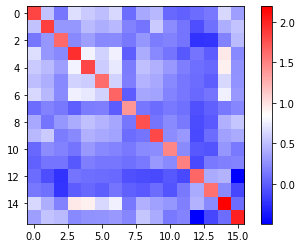

Average Non-Ictal


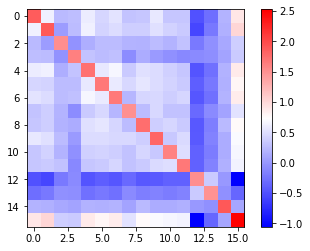

In [19]:
print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


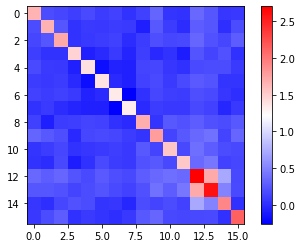

Average Non-Ictal


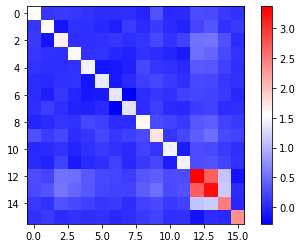

In [20]:
print("Average Ictal and Non-Ictal Simularity Matrix for GDE")
visualize_avg_sim_matrix(dm, sim_all["GDE_train"], sim_all["GDE_test"])

##### 3.1.3 MLP for GCN  

###### Training

In [21]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_all["GCN_train"], sim_all["GCN_test"], MLPparametersGCN, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=136, out_features=136, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=136, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 136]               0
            Linear-2                  [-1, 136]          18,632
              ReLU-3                  [-1, 136]               0
           Dropout-4                  [-1, 136]               0
            Linear-5                    [-1, 1]             137
           Sigmoid-6                    [-1, 1]               0
Total params: 18,769
Trainable params: 18,769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07

In [32]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGCN, "models/MLPGCN253_2.pt")

model saved


###### Result

In [22]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda', threshold = t)

device set to cuda
threshold: 0.05  validation loss: 0.3804 F1 accuracy 0.286 Precision accuracy 0.176 Recall accuracy 0.763 AUC accuracy: 0.691
device set to cuda
threshold: 0.1  validation loss: 0.3804 F1 accuracy 0.372 Precision accuracy 0.272 Recall accuracy 0.588 AUC accuracy: 0.691
device set to cuda
threshold: 0.15  validation loss: 0.3804 F1 accuracy 0.326 Precision accuracy 0.297 Recall accuracy 0.361 AUC accuracy: 0.691
device set to cuda
threshold: 0.2  validation loss: 0.3804 F1 accuracy 0.304 Precision accuracy 0.362 Recall accuracy 0.263 AUC accuracy: 0.691
device set to cuda
threshold: 0.25  validation loss: 0.3804 F1 accuracy 0.238 Precision accuracy 0.37 Recall accuracy 0.175 AUC accuracy: 0.691
device set to cuda
threshold: 0.3  validation loss: 0.3804 F1 accuracy 0.177 Precision accuracy 0.4 Recall accuracy 0.113 AUC accuracy: 0.691
device set to cuda
threshold: 0.35  validation loss: 0.3804 F1 accuracy 0.147 Precision accuracy 0.447 Recall accuracy 0.088 AUC accurac

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 3.1.2 MLP for GDE

###### Training

In [23]:
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGDE, _,_, MLPcheckpointGDE = MLP.train_MLP(dm, sim_all["GDE_train"], sim_all["GDE_test"], MLPparametersGDE, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=136, out_features=136, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=136, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 136]               0
            Linear-2                  [-1, 136]          18,632
              ReLU-3                  [-1, 136]               0
           Dropout-4                  [-1, 136]               0
            Linear-5                    [-1, 1]             137
           Sigmoid-6                    [-1, 1]               0
Total params: 18,769
Trainable params: 18,769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07

In [28]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGDE, "models/MLPGDE253_1.pt")

model saved


###### Result

In [24]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGDE, sim_all["GDE_test"], dm, device_name = 'cuda', threshold = t)

device set to cuda
threshold: 0.05  validation loss: 0.3461 F1 accuracy 0.298 Precision accuracy 0.181 Recall accuracy 0.851 AUC accuracy: 0.77
device set to cuda
threshold: 0.1  validation loss: 0.3461 F1 accuracy 0.389 Precision accuracy 0.28 Recall accuracy 0.639 AUC accuracy: 0.77
device set to cuda
threshold: 0.15  validation loss: 0.3461 F1 accuracy 0.46 Precision accuracy 0.447 Recall accuracy 0.474 AUC accuracy: 0.77
device set to cuda
threshold: 0.2  validation loss: 0.3461 F1 accuracy 0.328 Precision accuracy 0.505 Recall accuracy 0.242 AUC accuracy: 0.77
device set to cuda
threshold: 0.25  validation loss: 0.3461 F1 accuracy 0.189 Precision accuracy 0.469 Recall accuracy 0.119 AUC accuracy: 0.77
device set to cuda
threshold: 0.3  validation loss: 0.3461 F1 accuracy 0.133 Precision accuracy 0.484 Recall accuracy 0.077 AUC accuracy: 0.77
device set to cuda
threshold: 0.35  validation loss: 0.3461 F1 accuracy 0.094 Precision accuracy 0.526 Recall accuracy 0.052 AUC accuracy: 0.

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Questions for Nafiseh:
1. Shuffling the dataset greatly reduces overfitting and improves the accuracy. Can we shuffle the dataset? Is removing the overlapping signals a valid way to shuffle the dataset?
2. Even without shuffling the dataset, removing overlapping signals still greatly improves the validation accuracy. Should we remove the overlapping signal?
3. The built-in AUC metric in Scikit-learn yields a lot higher accuracy than the maximum F-score obatined. Is it normal? What is your AUC accuracy implementation?